In [1]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

Text(0, 0.5, 'Values')

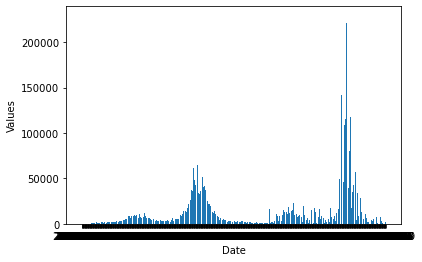

In [3]:
covid_df  = pd.read_csv('california_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)

plt.bar(covid_df['Date'], covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
plt.xlabel('Date')
plt.ylabel('Values')

<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT', ylabel='Count'>

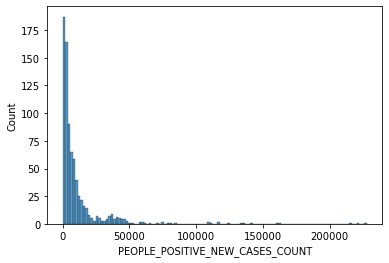

In [4]:
import seaborn as sns
sns.histplot(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])

Distribution is not normal, could be an opportunity for Linear Models.

In [5]:
covid_df  = covid_df.set_index('Date')
covid_df.index = pd.to_datetime(covid_df.index)
covid_df = covid_df.sort_index()

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(covid_df)

(-4.340033485942237,
 0.00037840560435706527,
 19,
 770,
 {'1%': -3.4388710830827125,
  '5%': -2.8653008652386576,
  '10%': -2.568772659807725},
 16271.0577646035)

Stationarity is Good. 

In [7]:
train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

## Cross val

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

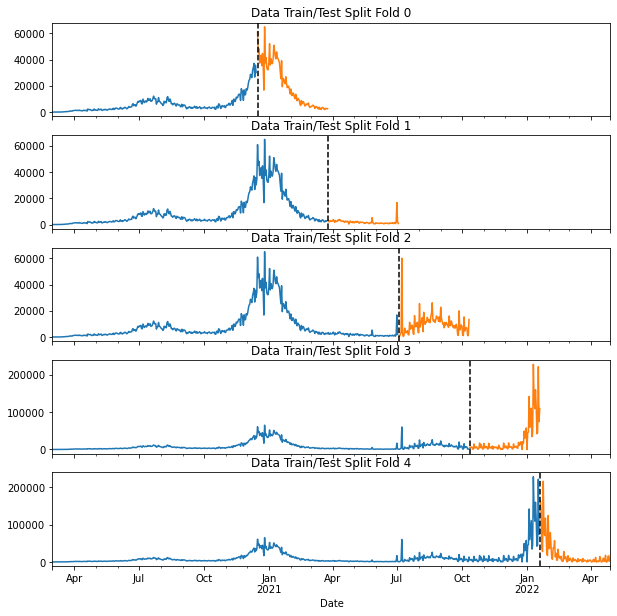

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_df):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## ACF & PACF

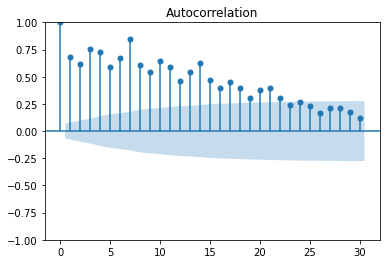

In [10]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

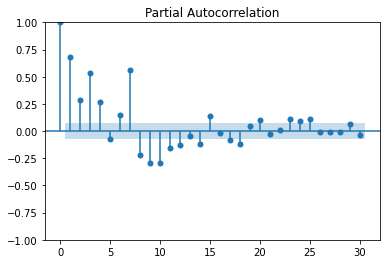

In [11]:
plot_pacf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

## Baseline ARIMA

In [12]:
from statsmodels.tsa.arima.model import ARIMA
base_cali_arima = ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(1, 0, 1))
base_cali_arima_fit = base_cali_arima.fit()

In [13]:
base_cali_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     PEOPLE_POSITIVE_NEW_CASES_COUNT   No. Observations:                  671
Model:                              ARIMA(1, 0, 1)   Log Likelihood               -6654.200
Date:                             Mon, 11 Mar 2024   AIC                          13316.400
Time:                                     23:23:54   BIC                          13334.435
Sample:                                 03-01-2020   HQIC                         13323.385
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8224.7381   9885.508      0.832      0.405   -1.12e+04    2.76e+04
ar.L1          0.9929      0.005    206.256      0.000       0.983       1.002
ma.L1         -0.6730      0.013    -53.073      0.000      -0.698      -0.648
sigma2      2.476e+07    212.510   1.17e+05      0.000    2.48e+07    2.48e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.43   Jarque-Bera (JB):             43063.53
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):              55.95   Skew:                             4.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.61e+28. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

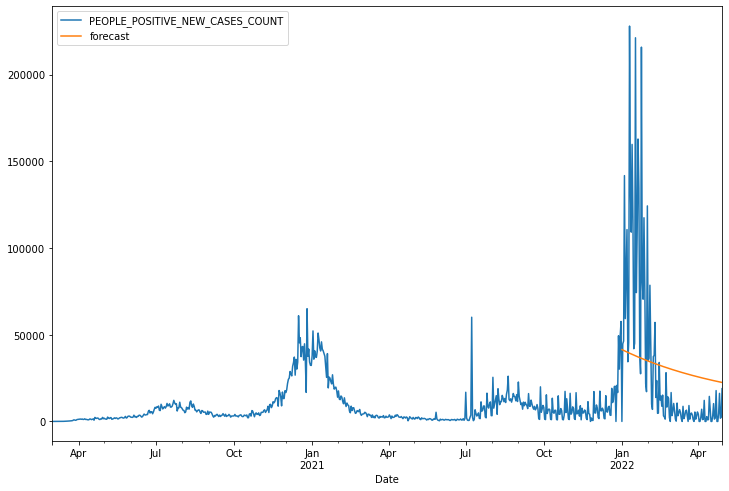

In [14]:
covid_df['forecast']= base_cali_arima_fit.forecast(steps = len(covid_test))
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

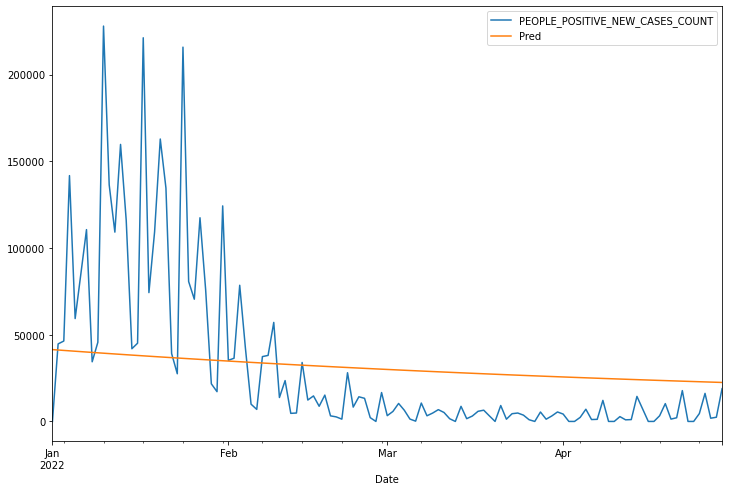

In [15]:
graph_df = pd.DataFrame(covid_test)
graph_df['Pred'] = base_cali_arima_fit.forecast(steps = len(covid_test))
graph_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','Pred']].plot(figsize=(12,8))

In [16]:
print('MAE = ', mean_absolute_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('MASE = ', mase(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred'])))

MAE =  31148.74283727297
MASE =  1.3317293342273766
RMSE =  45871.5830310543


## Tuned ARIMA

Going to try to do a Box Cox transformation to be used on linear models.

In [17]:
from scipy.stats import boxcox

covid_train_boxcox = pd.DataFrame(covid_train)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].clip(lower=1)
to_transform = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values
transformed_data, lambda_value = boxcox(to_transform)
print("Lambda value:", lambda_value)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'] = transformed_data

Lambda value: 0.20139950268370055


<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT_new', ylabel='Count'>

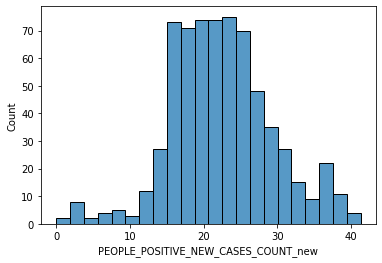

In [18]:
sns.histplot(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

New distribution here is much more normal than before, hopefully helps with improving the linear models. 

<BarContainer object of 671 artists>

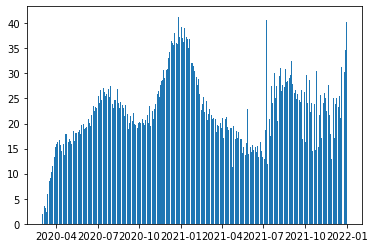

In [19]:
plt.bar(covid_train_boxcox.index, covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

In [147]:
# Grid Search

results=[]
for p in range(1,7):
    for q in range(1,7):
 #       cali_arima_gmodel=ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        cali_arima_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q)).fit()
        results.append([p,q,cali_arima_gmodel.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic').head(50)


,p,q,aic
35,6,6,3264.141836
34,6,5,3265.283137
28,5,5,3268.572188
33,6,4,3272.542525
23,4,6,3273.893594
32,6,3,3280.192910
29,5,6,3282.871670
27,5,4,3284.382771
30,6,1,3311.049371
17,3,6,3312.123531


In [172]:
cali_after_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(6,1,3))
cali_after_gmodel_fit =cali_after_gmodel.fit()

<AxesSubplot:xlabel='Date'>

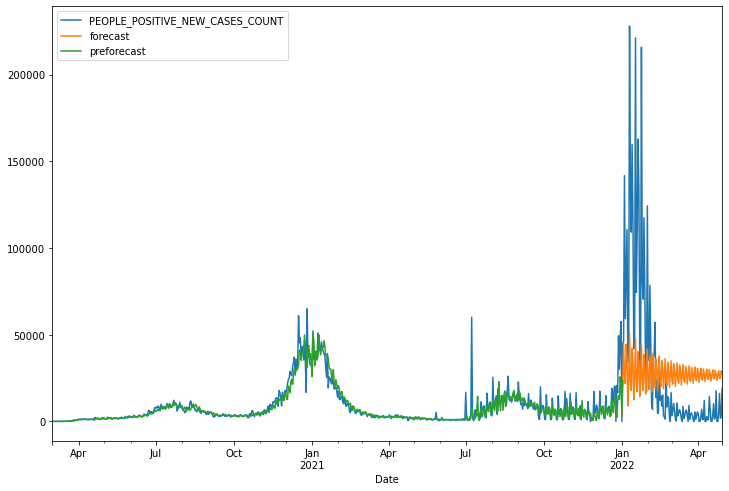

In [173]:
covid_df_predictions = pd.DataFrame(covid_df)

covid_df_predictions['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = covid_df_predictions['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['forecast'] = arima_back_transformed_one

covid_df_predictions['preforecast']= cali_after_gmodel_fit.predict(start = 0, end = 672)
arima_back_transform_two = covid_df_predictions['preforecast'].values
arima_back_transformed_two = np.power((arima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['preforecast'] = arima_back_transformed_two

covid_df_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

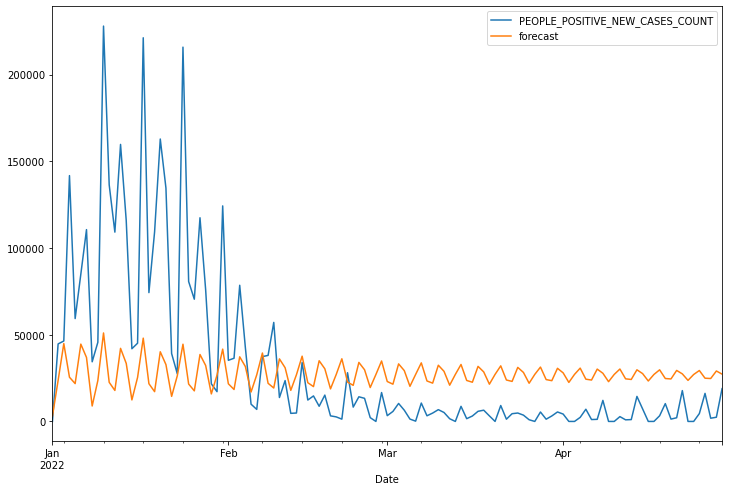

In [174]:
graph_df_1 = pd.DataFrame(covid_test)
graph_df_1['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_1['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_1['forecast'] = arima_back_transformed_one
graph_df_1[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [175]:
print('MAE = ', mean_absolute_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('MASE = ', mase(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast'])))

MAE =  32502.253579235483
MASE =  1.3895971579363458
RMSE =  46587.5118706995


## Baseline SARIMA

In [25]:
import statsmodels.api as sm
baseline_sarima= sm.tsa.statespace.SARIMAX(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarima = baseline_sarima.fit()

<AxesSubplot:xlabel='Date'>

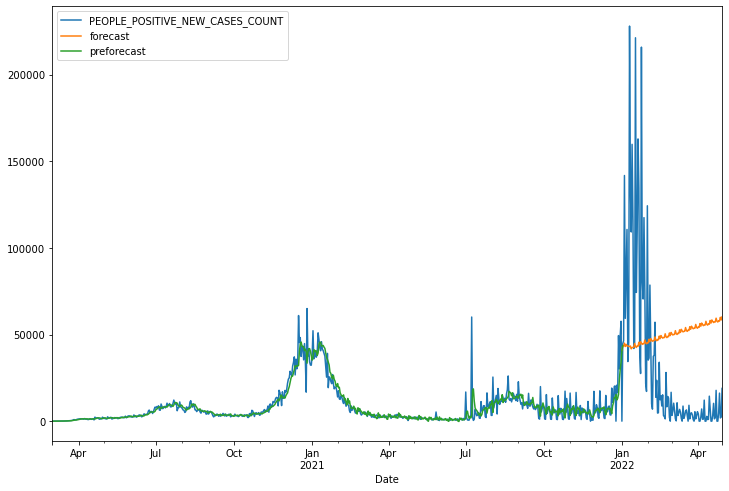

In [26]:
covid_df['forecast']= results_sarima.forecast(steps = len(covid_train))
covid_df['preforecast'] = results_sarima.predict(start = 0, end = 672)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

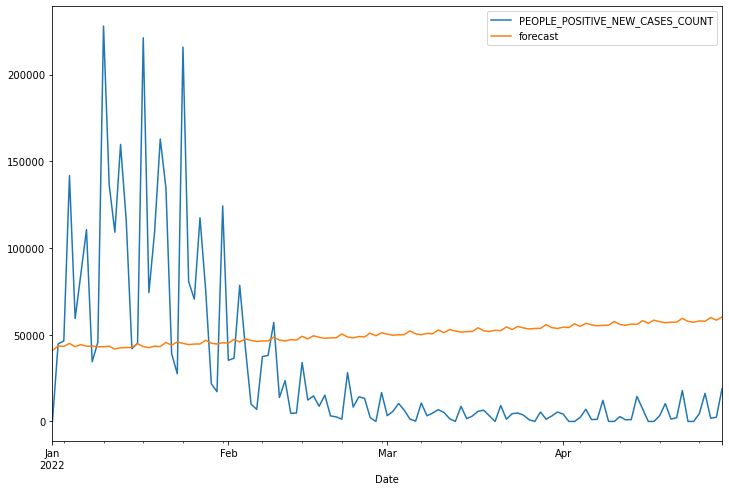

In [27]:
graph_df_3 = pd.DataFrame(covid_test)
graph_df_3['forecast']= results_sarima.forecast(steps = len(covid_test))
graph_df_3[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [28]:
print('MAE = ', mean_absolute_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('MASE = ', mase(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast'])))

MAE =  47544.640446352845
MASE =  2.0327174261407444
RMSE =  55991.254511090265


## Tuned SARIMA

In [29]:
'''
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    # Beaware of the data input, use your training set
                    model=sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])
'''

"\nif 1:\n    import statsmodels.api as sm\n\n    results=[]\n    for p in range(1,3):\n        for q in range(1,3):\n            for P in range(1,3):\n                for Q in range(1,3):\n                    print(p,q,P,Q)\n                    # Beaware of the data input, use your training set\n                    model=sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()\n                    results.append([p,q,P,Q,model.aic])\n"

In [30]:
#df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
#df_results

In [31]:
sarima = sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(1, 1, 2),seasonal_order=(1,1,2,12))
results = sarima.fit()

<AxesSubplot:xlabel='Date'>

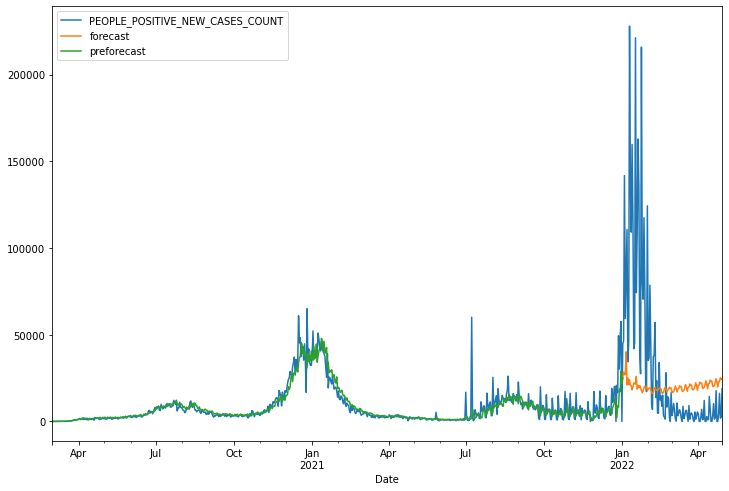

In [32]:
covid_df_sarima_predictions = pd.DataFrame(covid_df)

covid_df_sarima_predictions['forecast']=results.forecast(steps = len(covid_test))
sarima_back_transform_one = covid_df_sarima_predictions['forecast'].values
sarima_back_transformed_one = np.power((sarima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['forecast'] = sarima_back_transformed_one

covid_df_sarima_predictions['preforecast'] = results.predict(start = 0, end = 672)
sarima_back_transform_two = covid_df_sarima_predictions['preforecast'].values
sarima_back_transformed_two = np.power((sarima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['preforecast'] = sarima_back_transformed_two

covid_df_sarima_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

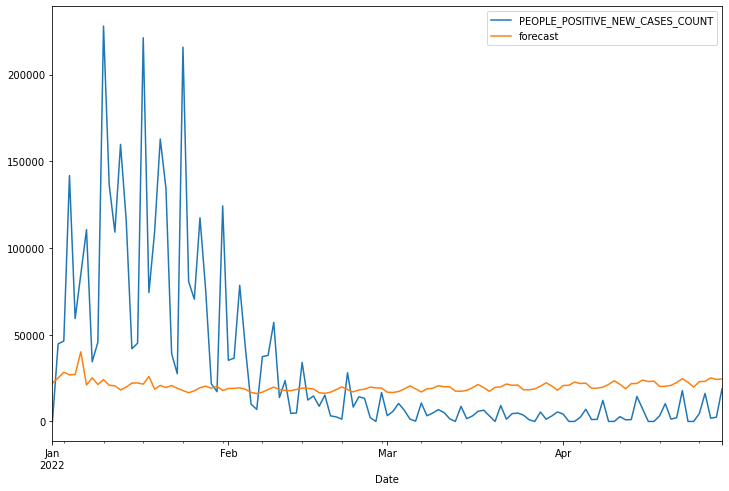

In [33]:
graph_df_4 = pd.DataFrame(covid_test)
graph_df_4['forecast']= results.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_4['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_4['forecast'] = arima_back_transformed_one
graph_df_4[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [34]:
print('MAE = ', mean_absolute_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('MASE = ', mase(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast'])))

MAE =  30515.254947005134
MASE =  1.304645274663406
RMSE =  50206.10458394023


## Auto-ARIMA

In [35]:
from pmdarima import auto_arima

In [36]:
auto_model = auto_arima(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'], seasonal=True, trace=True, suppress_warnings=True, stepwise=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3444.603, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3759.019, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3646.782, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3480.244, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3757.156, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3478.350, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3469.668, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3472.202, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3376.329, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3444.018, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3376.039, Time=1.21 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3376.080, Time=1.14 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3378.420, Time=1.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3375.745, Time=1.01 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

3365.179217366973


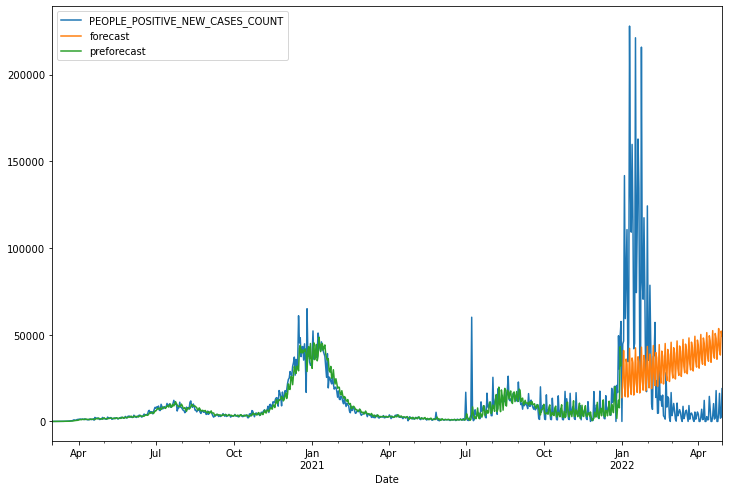

In [37]:
covid_auto_predictions = pd.DataFrame(covid_df)

auto_predictions = auto_model.predict(n_periods=len(covid_test))
auto_predictions = np.power((auto_predictions * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['forecast'] = auto_predictions

auto_predict_before = auto_model.fittedvalues()
auto_predict_before = np.power((auto_predict_before * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['preforecast'] = auto_predict_before

covid_auto_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))
print(auto_model.aic())

<AxesSubplot:xlabel='Date'>

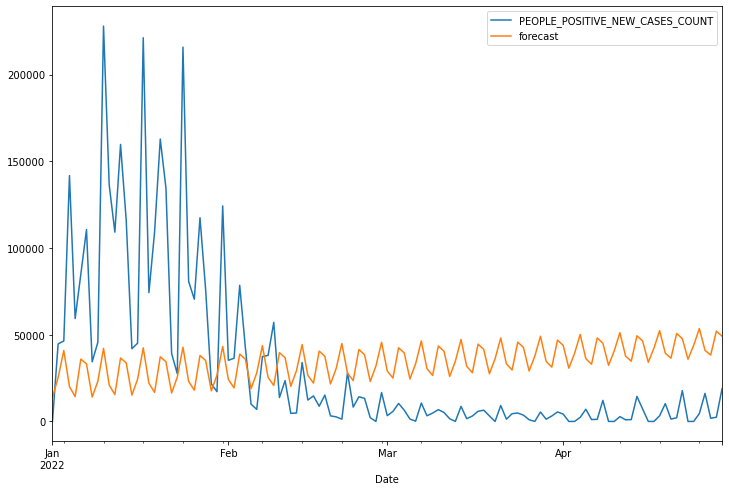

In [38]:
graph_df_5 = pd.DataFrame(covid_test)
graph_df_5['forecast']= auto_model.predict(n_periods=len(covid_test))
arima_back_transform_one = graph_df_5['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_5['forecast'] = arima_back_transformed_one
graph_df_5[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [39]:
print('MAE = ', mean_absolute_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('MASE = ', mase(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast'])))

MAE =  39998.7592803235
MASE =  1.7101017959083002
RMSE =  51699.17801185711
